# Large Scale Kernel Ridge Regression

In [3]:
import sys
sys.path.insert(0, '/Users/eman/Documents/code_projects/kernellib')
sys.path.insert(0, '/home/emmanuel/code/kernellib')

In [4]:
import numpy as np
from kernellib.large_scale import RKSKernelRidge, KernelRidge as RKernelRidge
from kernellib.utils import estimate_sigma, r_assessment
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Sample Data

In [5]:
seed = 123
rng = np.random.RandomState(seed)
n_train, n_test = 10000, 1000
d_dimensions = 1
noise = 0.1

xtrain = rng.randn(n_train, d_dimensions)
ytrain = np.sin(xtrain) + noise * rng.randn(n_train, d_dimensions)

xtest = rng.randn(n_test, d_dimensions)
ytest = np.sin(xtest) + noise * rng.randn(n_test, d_dimensions)

# training
n_components = 10
alpha = 1e-3

sigma = estimate_sigma(xtrain)

## Random Kitchen Sinks Regression

In this method, I implement the Random Kitchen Sinks algorithm found [here](https://people.eecs.berkeley.edu/~brecht/kitchensinks.html) and [here](https://people.eecs.berkeley.edu/~brecht/kitchensinks.html). I don't try and transform the problem into a matrix approximation and then fit it into the KRR framework. This is largely because the RKS algorithm that they implement use complex values that need to be present in solving and transforming the data. If the complex values are taken out before the transformation, the results are garbage. Furthermore, some experiments that I ran (see below) show that the RKS as a transformer do not approximate the kernel matrix very well. So therefore, this algorithm comes as is. It's a shame that you cannot write the function as a transformer but the phenomenal results that you obtain make it worth it in my opinion.

In [10]:
rks_model = RKSKernelRidge(n_components=n_components, alpha=alpha, sigma=sigma, 
                           random_state=seed)
rks_model.fit(xtrain, ytrain)
y_pred = rks_model.predict(xtest)
r_assessment(y_pred, ytest, verbose=1);

              mae       mse        r2      rmse
Results  0.079758  0.009984  0.976223  0.099922


In [7]:
%timeit rks_model.fit(xtrain, ytrain);
%timeit rks_model.predict(xtest);

3.38 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
278 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


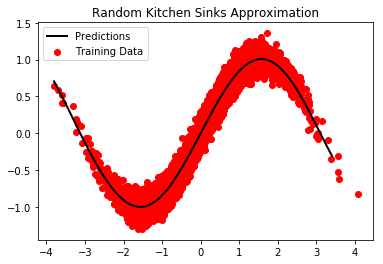

In [11]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rks_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Random Kitchen Sinks Approximation')
plt.show()

#### Cross Validation Compatibility

In [52]:
sigmaMin = np.log10(sigma*0.1);
sigmaMax = np.log10(sigma*10);
sigmas = np.logspace(sigmaMin,sigmaMax,20);

param_grid = {
    'n_components': [1, 5, 10, 25],
    'alpha': [1e0, 1e-1, 1e-2, 1e-3],
    'sigma': sigmas
}

n_jobs = 24
cv = 3

rks_grid_model = GridSearchCV(RKSKernelRidge(random_state=seed),
                          param_grid=param_grid, n_jobs=n_jobs, cv=cv, 
                          verbose=1)
rks_grid_model.fit(xtrain, ytrain);

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 672 tasks      | elapsed:    2.3s
[Parallel(n_jobs=24)]: Done 960 out of 960 | elapsed:    3.3s finished


In [53]:
y_pred = rks_grid_model.predict(xtest)
r_assessment(y_pred, ytest)

,mae,mse,r2,rmse
Results,0.079709,0.009977,0.976238,0.099885


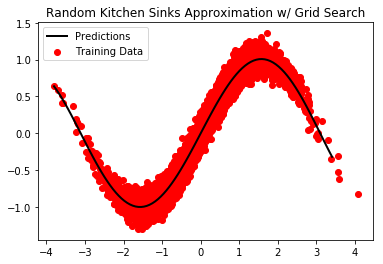

In [54]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rks_grid_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Random Kitchen Sinks Approximation w/ Grid Search')
plt.show()

## Nystrom Approximation

In [15]:
approximation = 'nystrom'
nys_model = RKernelRidge(n_components=n_components,
                         alpha=alpha,
                         sigma=sigma,
                         kernel='rbf',
                         random_state=seed,
                         approximation=approximation)
nys_model.fit(xtrain, ytrain);
y_pred = nys_model.predict(xtest)
r_assessment(y_pred, ytest, verbose=1);

              mae       mse       r2      rmse
Results  0.080484  0.010232  0.97562  0.101152


In [16]:
%timeit nys_model.fit(xtrain, ytrain);
%timeit nys_model.predict(xtest);

1.95 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
279 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


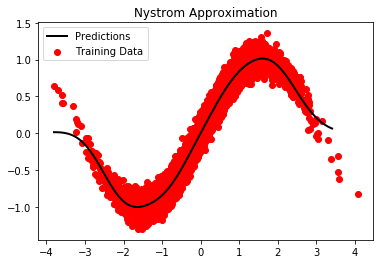

In [17]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = nys_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Nystrom Approximation')
plt.show()

### Nystrom w/ Grid Search

In [42]:

sigmaMin = np.log10(sigma*0.1);
sigmaMax = np.log10(sigma*10);
sigmas = np.logspace(sigmaMin,sigmaMax,20);

param_grid = {
    'kernel': ['rbf'],
    'n_components': [1, 5, 10, 25],
    'alpha': [1e0, 1e-1, 1e-2, 1e-3],
    'sigma': sigmas
}
n_jobs = 24
cv = 3

nys_grid_model = GridSearchCV(RKernelRidge(random_state=seed,
                                       approximation=approximation),
                          param_grid=param_grid, n_jobs=n_jobs, cv=cv, 
                          verbose=1)
nys_grid_model.fit(xtrain, ytrain);

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 464 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 960 out of 960 | elapsed:    6.0s finished


In [45]:
r_assessment(y_pred, ytest, verbose=1);
print('Best sigma:', nys_grid_model.best_estimator_.sigma)
print('Best alpha:',nys_grid_model.best_estimator_.alpha)
print('Best Number of features:', nys_grid_model.best_estimator_.n_components)
print('Best Kernel:', nys_grid_model.best_estimator_.kernel)

              mae       mse       r2      rmse
Results  0.079583  0.009968  0.97625  0.099838
Best sigma: 1.1288378916846888
Best alpha: 0.1
Best Number of features: 10
Best Kernel: rbf


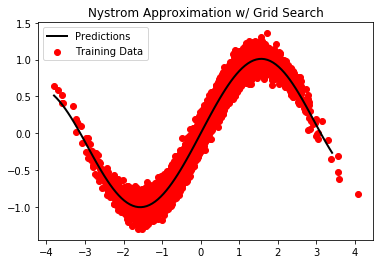

In [44]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = nys_grid_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Nystrom Approximation w/ Grid Search')
plt.show()

## Randomized Nystrom Matrix Approximation

In [46]:
approximation = 'rnystrom'
k_rank = 10
rnys_model = RKernelRidge(n_components=n_components,
                         alpha=alpha,
                         sigma=sigma,
                         kernel='rbf',
                         random_state=seed,
                         approximation=approximation,
                         k_rank=k_rank)
rnys_model.fit(xtrain, ytrain);
y_pred = rnys_model.predict(xtest)
r_assessment(y_pred, ytest, verbose=1);

              mae       mse        r2      rmse
Results  0.080322  0.010202  0.975668  0.101003


In [47]:
%timeit rnys_model.fit(xtrain, ytrain);
%timeit rnys_model.predict(xtest);

2.44 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
301 µs ± 52.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


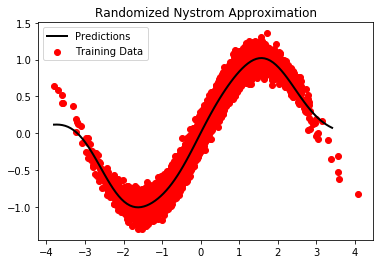

In [48]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rnys_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Randomized Nystrom Approximation')
plt.show()

## Random Fourier Features Approximation

In [49]:
approximation = 'rff'
rff_model = RKernelRidge(n_components=n_components,
                         alpha=alpha,
                         sigma=sigma,
                         kernel='rbf',
                         random_state=seed,
                         approximation=approximation)
rff_model.fit(xtrain, ytrain);
y_pred = rff_model.predict(xtest)
r_assessment(y_pred, ytest, verbose=1);

              mae       mse        r2      rmse
Results  0.079697  0.009976  0.976239  0.099879


In [50]:
%timeit rff_model.fit(xtrain, ytrain);
%timeit rff_model.predict(xtest);

5.5 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
80.5 µs ± 4.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


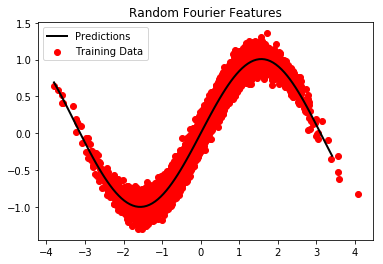

In [51]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rff_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Random Fourier Features')
plt.show()

### Fast Food

In [34]:
approximation = 'fastfood'
fastfood_model = RKernelRidge(n_components=n_components,
                         alpha=alpha,
                         sigma=sigma,
                         kernel='rbf',
                         random_state=seed,
                         approximation=approximation,
                            trade_off='mem')
fastfood_model.fit(xtrain, ytrain);
y_pred = fastfood_model.predict(xtest)
r_assessment(y_pred, ytest, verbose=1);

              mae       mse       r2      rmse
Results  0.079583  0.009968  0.97625  0.099838


In [35]:
%timeit fastfood_model.fit(xtrain, ytrain);
%timeit fastfood_model.predict(xtest);

4.8 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
524 µs ± 72.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


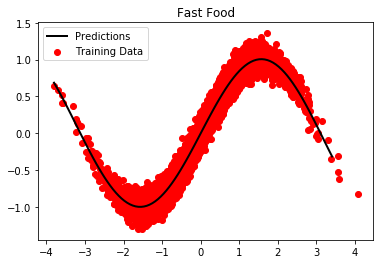

In [36]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = fastfood_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Fast Food')
plt.show()

### Timing Comparison

#### Number of Features

In [150]:
from sklearn.datasets import make_low_rank_matrix
import seaborn; seaborn.set()

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [157]:
m_range = (2 ** (np.arange(12.3, 20))).astype(int)
print(m_range.shape, m_range.min(), m_range.max())

(8,) 5042 645474


In [158]:
from sklearn.datasets import make_regression

In [159]:
print(t1.average, t1.stdev)

0.46411639344712186 0.002118701198427


In [160]:
%%time 
t_rks = list()
t_nys = list()
t_rnys = list()
t_rbf = list()
t_rff = list()

# training
n_components = 50
alpha = 1e-3
gamma = 1.0

for m in m_range:
    xtrain, ytrain = make_regression(n_samples=m, n_features=2000,
                                     n_informative=200, n_targets=1,
                                     effective_rank=50, noise=0.2, 
                                     random_state=seed)
    print(xtrain.shape)
    # -------------------------------
    # Random Kitchen Sinks)
    # -------------------------------
    rks_model = RKSKernelRidge(n_components=n_components, alpha=alpha, 
                               gamma=gamma, random_state=seed)
    t1 = %timeit -oq rks_model.fit(xtrain, ytrain)
    
    # ------------------------------
    # Nystrom
    # ------------------------------
    approximation = 'nystrom'
    nys_model = RKernelRidge(n_components=n_components,
                             alpha=alpha,
                             gamma=gamma,
                             kernel='rbf',
                             random_state=seed,
                             approximation=approximation)
    t2 = %timeit -oq nys_model.fit(xtrain, ytrain);

    # ----------------------------
    # Randomized Nystrom
    # ----------------------------
    approximation = 'rnystrom'
    k_rank = n_components
    rnys_model = RKernelRidge(n_components=n_components,
                             alpha=alpha,
                             gamma=gamma,
                             kernel='rbf',
                             random_state=seed,
                             approximation=approximation,
                             k_rank=k_rank)
    t3 = %timeit -oq rnys_model.fit(xtrain, ytrain);
    
    # -----------------------------------
    # RBF Sampler (Random Kitchen Sinks)
    # -----------------------------------
    approximation = 'rks'
    rks_model = RKernelRidge(n_components=n_components,
                             alpha=alpha,
                             gamma=gamma,
                             kernel='rbf',
                             random_state=seed,
                             approximation=approximation)
    t4 = %timeit -oq rks_model.fit(xtrain, ytrain);   
    
    # -----------------------------
    # Random Fourier Features
    # -----------------------------
    approximation = 'rff'
    rff_model = RKernelRidge(n_components=n_components,
                             alpha=alpha,
                             gamma=gamma,
                             kernel='rbf',
                             random_state=seed,
                             approximation=approximation)
    t5 = %timeit -oq rff_model.fit(xtrain, ytrain);      
    
    t_rks.append(t1.best)
    t_nys.append(t2.best)
    t_rnys.append(t3.best)
    t_rbf.append(t4.best)
    t_rff.append(t5.best)
    

    
    

(5042, 2000)
(10085, 2000)
(20171, 2000)
(40342, 2000)
(80684, 2000)
(161368, 2000)
(322737, 2000)
(645474, 2000)
CPU times: user 2h 4min 38s, sys: 4h 15min 33s, total: 6h 20min 11s
Wall time: 34min 36s


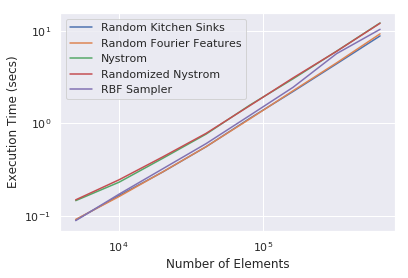

In [162]:


plt.loglog(m_range, t_rks, label='Random Kitchen Sinks')
plt.loglog(m_range, t_rff, label='Random Fourier Features')
plt.loglog(m_range, t_nys, label='Nystrom')
plt.loglog(m_range, t_rnys, label='Randomized Nystrom')
plt.loglog(m_range, t_rbf, label='RBF Sampler')
plt.legend(loc='upper left')
plt.xlabel('Number of Elements')
plt.ylabel('Execution Time (secs)');



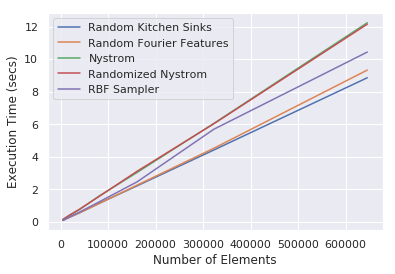

In [163]:
plt.plot(m_range, t_rks, label='Random Kitchen Sinks')
plt.plot(m_range, t_rff, label='Random Fourier Features')
plt.plot(m_range, t_nys, label='Nystrom')
plt.plot(m_range, t_rnys, label='Randomized Nystrom')
plt.plot(m_range, t_rbf, label='RBF Sampler')
plt.legend(loc='upper left')
plt.xlabel('Number of Elements')
plt.ylabel('Execution Time (secs)');
